# Oscar Data Science Take Home
By Isaac Golberg  
Last Edited: August 3, 2023

## Goal

Infer member health issues using diagnosis and prescription drugs, a model which can generalize to other data points.
Can be used to detect who is not receiving required medical care or unusual care patterns.

## Data

According to the pdf, the data is over 200,000 members over a three year period (will verify through EDA).

#### claim_lines
Diagnosis code given to a member on a given day. 

Note: Diagnosis codes are in ICD-10 format

#### ccs
Mapping table for diagnosis code to higher level clinical categories.

ccs_1_desc has lowest unique value count so most likely highest level.

ccs_3_desc has highest unique value count so most likely the most granular level.

Note: Diagnosis value formatting in claim_lines is different from here so will need to be corrected for before joining. Not all diagnosis codes have CCS codes.

#### prescription_drugs
Drug prescription filled by a member identified by National Drug Code(NDC) along with the drug cztegory, drug group, and drug class.

##### Import necessary libraries and read in data

In [217]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import squarify
%matplotlib inline

import openai
import os

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [2]:
prescription_drugs = pd.read_csv('/Users/isaacgolberg/Downloads/Data_(Researcher)_Case_Study_Datasets/prescription_drugs.csv')

In [3]:
claim_lines = pd.read_csv('/Users/isaacgolberg/Downloads/Data_(Researcher)_Case_Study_Datasets/claim_lines.csv')

In [4]:
ccs = pd.read_csv('/Users/isaacgolberg/Downloads/Data_(Researcher)_Case_Study_Datasets/ccs.csv')

## EDA

In [5]:
prescription_drugs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3005934 entries, 0 to 3005933
Data columns (total 7 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   record_id      int64 
 1   member_id      object
 2   date_svc       object
 3   ndc            int64 
 4   drug_category  object
 5   drug_group     object
 6   drug_class     object
dtypes: int64(2), object(5)
memory usage: 160.5+ MB


In [6]:
prescription_drugs.head()

,record_id,member_id,date_svc,ndc,drug_category,drug_group,drug_class
0,4115084976453758912,M0023556,2016-05-08,51285040702,Estrogens,Estrogens,Estrogens
1,1750642805638674193,M0087538,2016-12-05,50474080303,Antiparkinson and Related Therapy Agents,Antiparkinson Dopaminergics,Nonergoline Dopamine Receptor Agonists
2,5543689263541245391,M0049608,2018-01-18,3089421,Anticoagulants,Direct Factor Xa Inhibitors,Direct Factor Xa Inhibitors
3,5952194046467620061,M0175153,2017-01-28,603580321,Gastrointestinal Agents - Misc.,Inflammatory Bowel Agents,Inflammatory Bowel Agents
4,1809570950798791089,M0152187,2016-05-13,591396501,Progestins,Progestins,Progestins


In [7]:
claim_lines.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1919983 entries, 0 to 1919982
Data columns (total 4 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   record_id  int64 
 1   member_id  object
 2   date_svc   object
 3   diag1      object
dtypes: int64(1), object(3)
memory usage: 58.6+ MB


In [8]:
claim_lines.member_id.nunique()

245166

##### A bit more members than the pdf had mentioned

In [9]:
claim_lines['date_svc'] = claim_lines['date_svc'].apply(lambda x: pd.to_datetime(x, format='%Y-%m-%d'))

In [10]:
claim_lines.date_svc.min()

Timestamp('1899-12-04 00:00:00')

In [11]:
claim_lines.date_svc.max()

Timestamp('2018-12-06 00:00:00')

##### The exercise doesn't call for it, but it seems like there are some issues with the data. The minimum date is in 1899 which is contradictory to the pdf which stated it contains member records over a three year period.

In [29]:
claim_lines[claim_lines['date_svc'] < '2015-01-01'].count()

record_id    38
member_id    38
date_svc     38
diag1        38
dtype: int64

##### In the interest of time, I will not investigate why these records exist and I will simply drop them to get closer to the expected time period outlined in the pdf.

In [30]:
claim_lines = claim_lines[claim_lines['date_svc'] > '2015-01-01']

In [31]:
claim_lines.head()

,record_id,member_id,date_svc,diag1
0,57738,M0000001,2015-12-06,N92.6
1,57750,M0000001,2015-12-06,O26.842
2,65072,M0000001,2015-12-13,O26.842
3,201796,M0000001,2016-02-29,O26.843
4,267197,M0000001,2016-03-27,O26.843


In [32]:
prescription_drugs['date_svc'] = prescription_drugs['date_svc'].apply(lambda x: pd.to_datetime(x, format='%Y-%m-%d'))

In [37]:
prescription_drugs[prescription_drugs['date_svc'] < '2014-01-01'].count()

record_id        466
member_id        466
date_svc         466
ndc              466
drug_category    466
drug_group       466
drug_class       466
dtype: int64

In [38]:
prescription_drugs['date_svc'].describe()

/var/folders/03/68l938rj3wn6cydyfg471dd40000gn/T/ipykernel_59132/2354848398.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  prescription_drugs['date_svc'].describe()


count                 3005934
unique                   1644
top       2018-03-27 00:00:00
freq                     5881
first     2013-12-04 00:00:00
last      2018-06-04 00:00:00
Name: date_svc, dtype: object

##### I will do the same for prescription drugs, but set the date at 2014 because we would be dropping a lot more records if we start in 2015

In [39]:
prescription_drugs = prescription_drugs[prescription_drugs['date_svc'] > '2014-01-01']

In [40]:
ccs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72167 entries, 0 to 72166
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   diag        72167 non-null  object
 1   diag_desc   72167 non-null  object
 2   ccs_1_desc  72167 non-null  object
 3   ccs_2_desc  72167 non-null  object
 4   ccs_3_desc  72167 non-null  object
dtypes: object(5)
memory usage: 2.8+ MB


In [41]:
ccs.head()

,diag,diag_desc,ccs_1_desc,ccs_2_desc,ccs_3_desc
0,A000,"Cholera due to Vibrio cholerae 01, biovar chol...",Diseases of the digestive system,Intestinal infection [135.],Intestinal infection
1,A001,"Cholera due to Vibrio cholerae 01, biovar eltor",Diseases of the digestive system,Intestinal infection [135.],Intestinal infection
2,A009,"Cholera, unspecified",Diseases of the digestive system,Intestinal infection [135.],Intestinal infection
3,A0100,"Typhoid fever, unspecified",Diseases of the digestive system,Intestinal infection [135.],Intestinal infection
4,A0101,Typhoid meningitis,Diseases of the nervous system and sense organs,Central nervous system infection,Meningitis (except that caused by tuberculosis...


In [42]:
prescription_drugs[['drug_category', 'drug_group', 'drug_class']].describe()

,drug_category,drug_group,drug_class
count,3005427,3005427,3005427
unique,92,464,687
top,Antidepressants,Hmg CoA Reductase Inhibitors,Hmg CoA Reductase Inhibitors
freq,271625,147946,147934


In [43]:
claim_lines[['date_svc', 'diag1']].describe()

/var/folders/03/68l938rj3wn6cydyfg471dd40000gn/T/ipykernel_59132/2842518833.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  claim_lines[['date_svc', 'diag1']].describe()


,date_svc,diag1
count,1919921,1919921
unique,1113,20566
top,2018-02-15 00:00:00,Z00.00
freq,4237,70352
first,2015-01-02 00:00:00,NaN
last,2018-12-06 00:00:00,NaN


In [47]:
ccs.describe()

,diag,diag_desc,ccs_1_desc,ccs_2_desc,ccs_3_desc
count,72167,72167,72167,72167,72167
unique,72167,71961,18,136,283
top,A000,Concussion with loss of consciousness greater ...,Injury and poisoning,Fractures,Fracture of lower limb
freq,1,6,40432,16924,6888


##### From the unique count, it seems like ccs_1_desc is a more general code for different diagnostics. ccs_2_desc becomes a bit more granular and ccs_3_desc would seem to be the most granular out of the three. Spot checks will need to be done as well to try and build narratives for some patients to make sure we have a solid understanding of the data.

In [48]:
# Checking for missing values
print("Claim Lines Missing Values:")
print(claim_lines.isnull().sum())
print("\nCCS Missing Values:")
print(ccs.isnull().sum())
print("\nPrescription Drugs Missing Values:")
print(prescription_drugs.isnull().sum())

Claim Lines Missing Values:
record_id    0
member_id    0
date_svc     0
diag1        0
dtype: int64

CCS Missing Values:
diag          0
diag_desc     0
ccs_1_desc    0
ccs_2_desc    0
ccs_3_desc    0
dtype: int64

Prescription Drugs Missing Values:
record_id        0
member_id        0
date_svc         0
ndc              0
drug_category    0
drug_group       0
drug_class       0
dtype: int64


#### After looking at the data, claim_lines seems to have an unnecessary period in the diagnosis code which will need to be removed in order to tie to the ccs mapping data.

In [49]:
claim_lines['diag1'] = claim_lines['diag1'].apply(lambda x: x.replace('.', ''))

##### It will be useful later to have all of the ccs data tied to each claim for building characterizations.

In [50]:
# Get ccs codes for each claim
df = claim_lines.merge(ccs, how='left', left_on='diag1', right_on='diag')

In [51]:
df.head()

,record_id,member_id,date_svc,diag1,diag,diag_desc,ccs_1_desc,ccs_2_desc,ccs_3_desc
0,57738,M0000001,2015-12-06,N926,N926,"Irregular menstruation, unspecified",Diseases of the genitourinary system,Diseases of female genital organs,Menstrual disorders
1,57750,M0000001,2015-12-06,O26842,O26842,"Uterine size-date discrepancy, second trimester",Complications of pregnancy; childbirth; and th...,Complications mainly related to pregnancy,Other complications of pregnancy
2,65072,M0000001,2015-12-13,O26842,O26842,"Uterine size-date discrepancy, second trimester",Complications of pregnancy; childbirth; and th...,Complications mainly related to pregnancy,Other complications of pregnancy
3,201796,M0000001,2016-02-29,O26843,O26843,"Uterine size-date discrepancy, third trimester",Complications of pregnancy; childbirth; and th...,Complications mainly related to pregnancy,Other complications of pregnancy
4,267197,M0000001,2016-03-27,O26843,O26843,"Uterine size-date discrepancy, third trimester",Complications of pregnancy; childbirth; and th...,Complications mainly related to pregnancy,Other complications of pregnancy


In [112]:
print("\nClaims + CCS Missing Values:")
print(df.isnull().sum())


Claims + CCS Missing Values:
record_id        0
member_id        0
date_svc         0
diag1            0
diag          2071
diag_desc     2071
ccs_1_desc    2071
ccs_2_desc    2071
ccs_3_desc    2071
dtype: int64


##### We do not have a mapping for some records.

##### Look at frequency for clinical categories

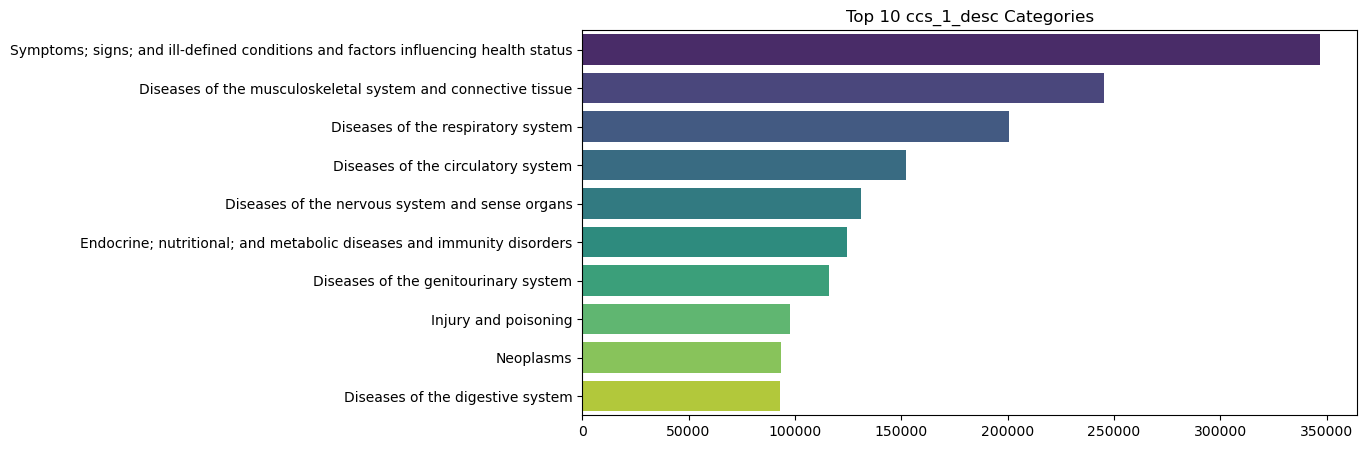

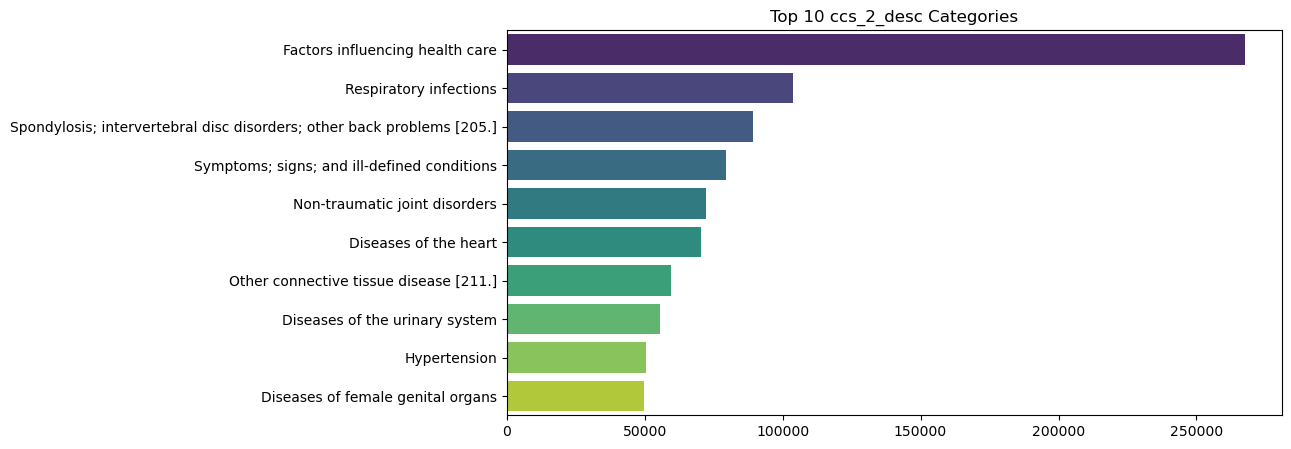

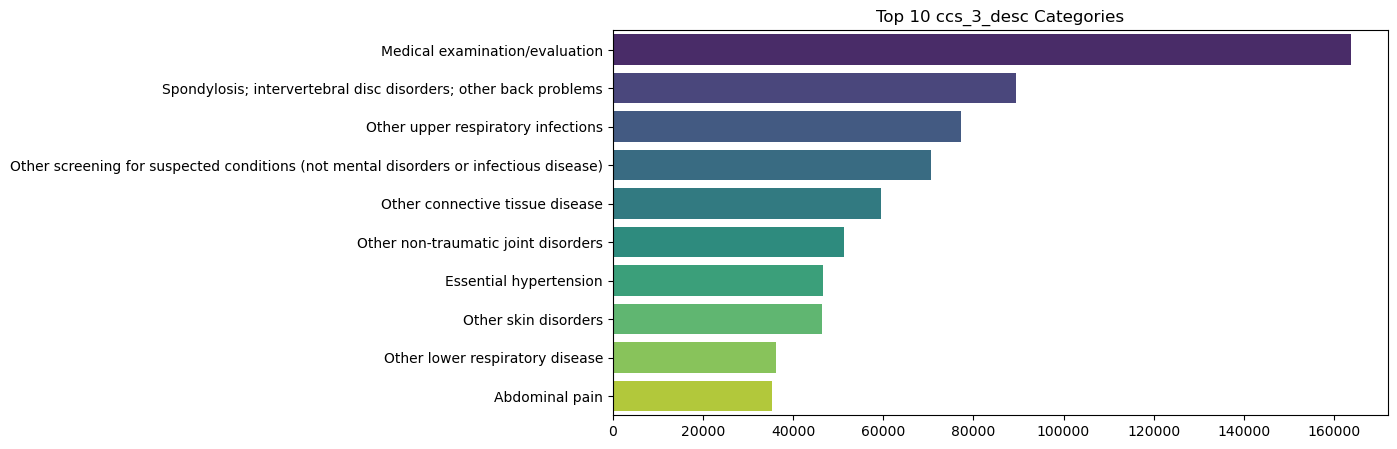

In [62]:
# Top 10 Clinical Categories
for col in ['ccs_1_desc', 'ccs_2_desc', 'ccs_3_desc']:
    top_ccs = df[col].value_counts().head(10)
    plt.figure(figsize=(10, 5))
    sns.barplot(y=top_ccs.index, x=top_ccs.values, palette='viridis')
    plt.title(f'Top 10 {col} Categories')

##### Given more time I would have wanted to investigate hierarchical relationships a bit more, potentially with a dendrogram.

##### Look at prescriptions over time

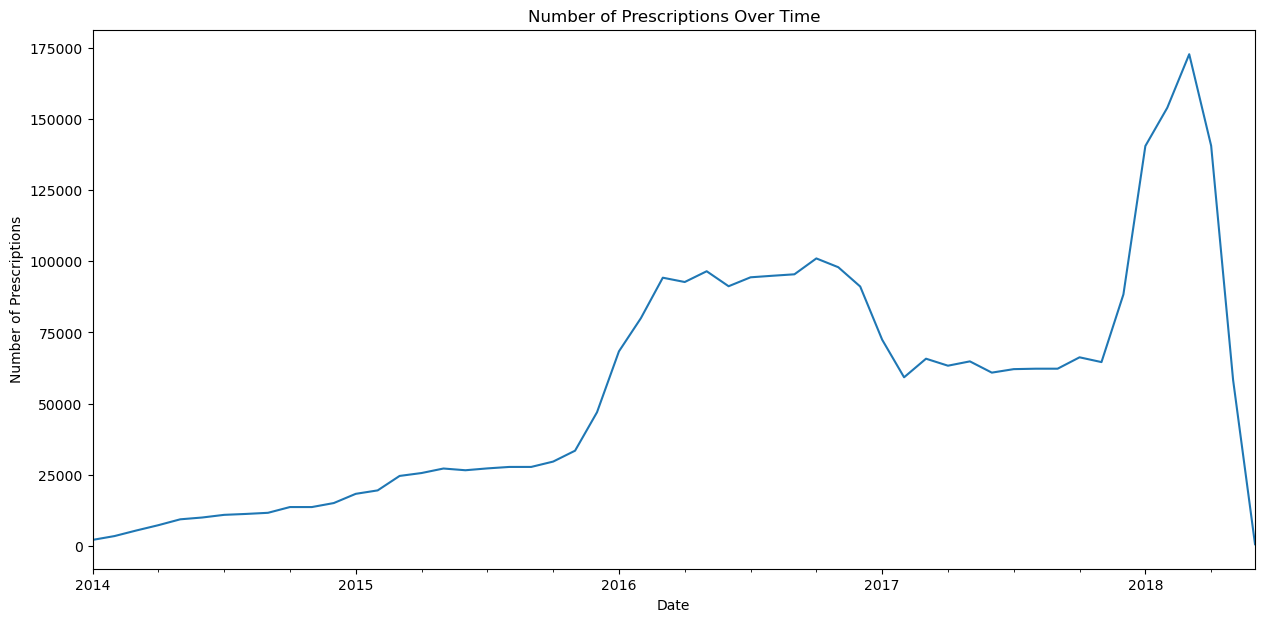

In [67]:
# Extract month and year from date_svc
prescription_drugs['YearMonth'] = prescription_drugs['date_svc'].dt.to_period('M')

# Plot prescriptions over time
plt.figure(figsize=(15, 7))
prescription_drugs.groupby('YearMonth')['record_id'].count().plot(kind='line')
plt.title('Number of Prescriptions Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Prescriptions')
plt.show()

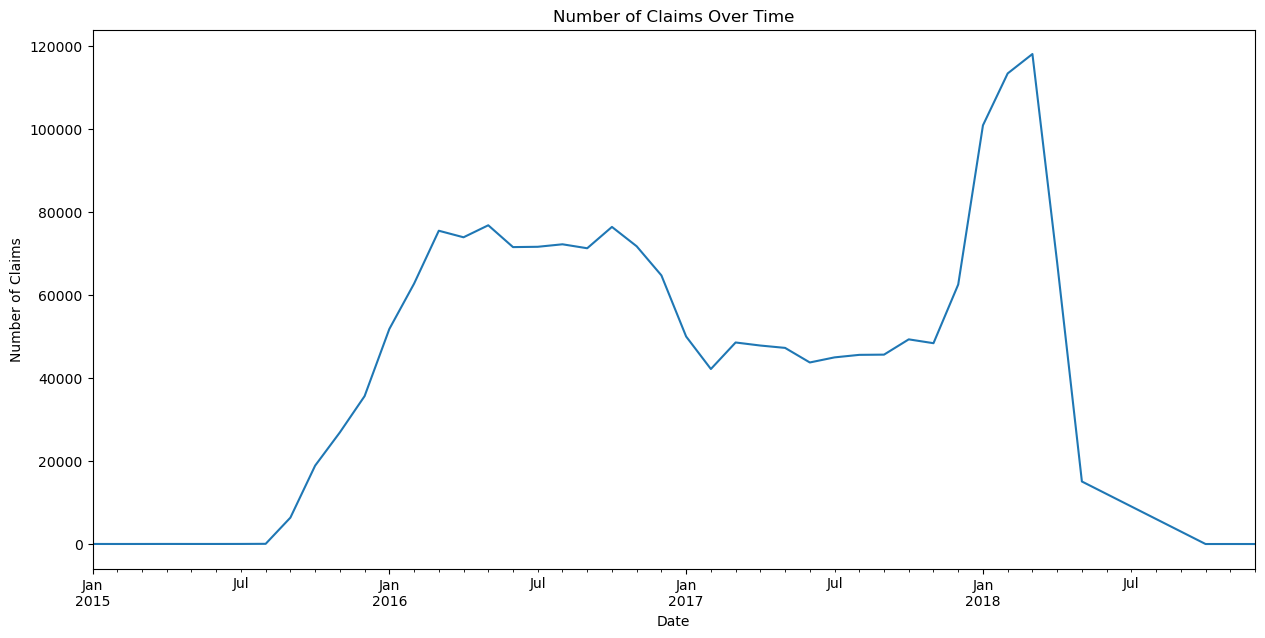

In [69]:
# Extract month and year from date_svc
claim_lines['YearMonth'] = claim_lines['date_svc'].dt.to_period('M')

# Plot prescriptions over time
plt.figure(figsize=(15, 7))
claim_lines.groupby('YearMonth')['record_id'].count().plot(kind='line')
plt.title('Number of Claims Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Claims')
plt.show()

##### The number of prescriptions seems to follow the same trend as the number of claims with respect to time. This would match my intuition and is a relatively good sign. We can see prescriptions are lagging a bit (e.g. an increase in prescriptions filled increases shortly after there as an uptick in claims.

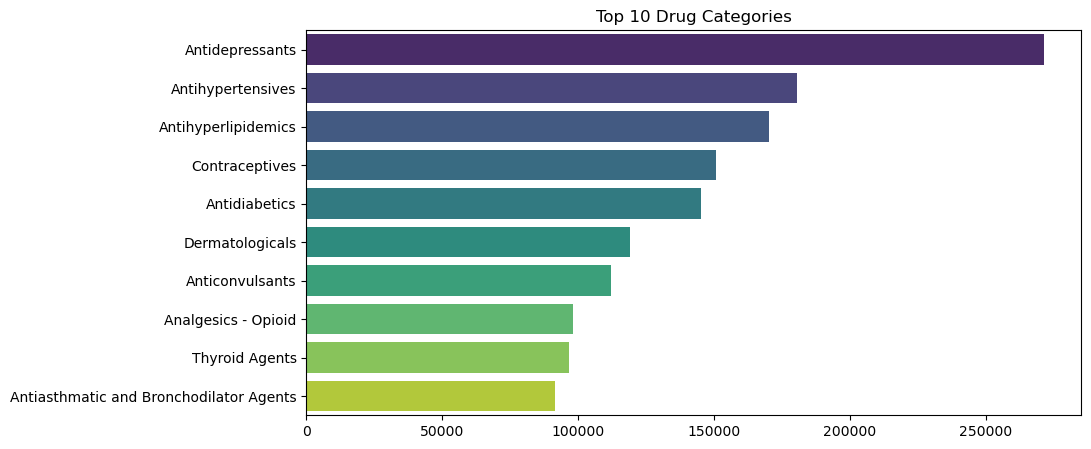

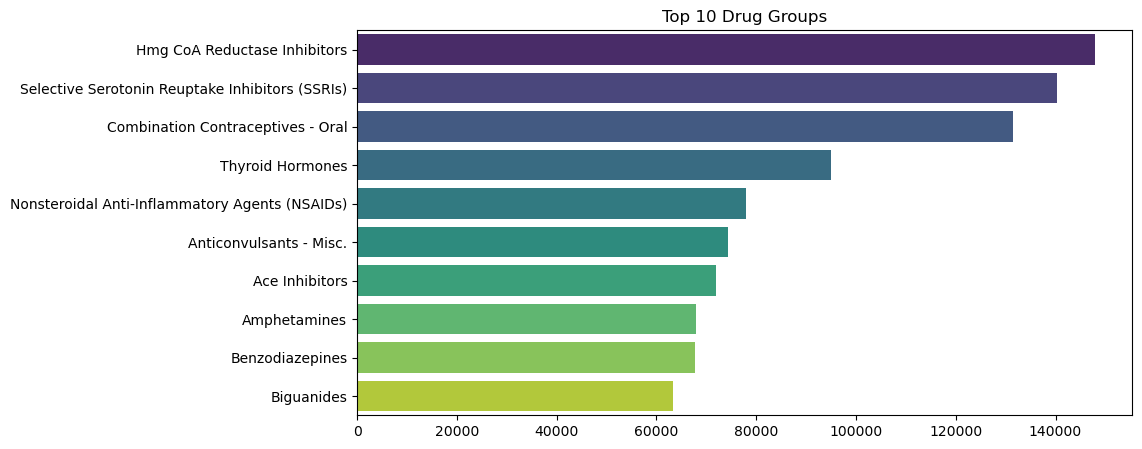

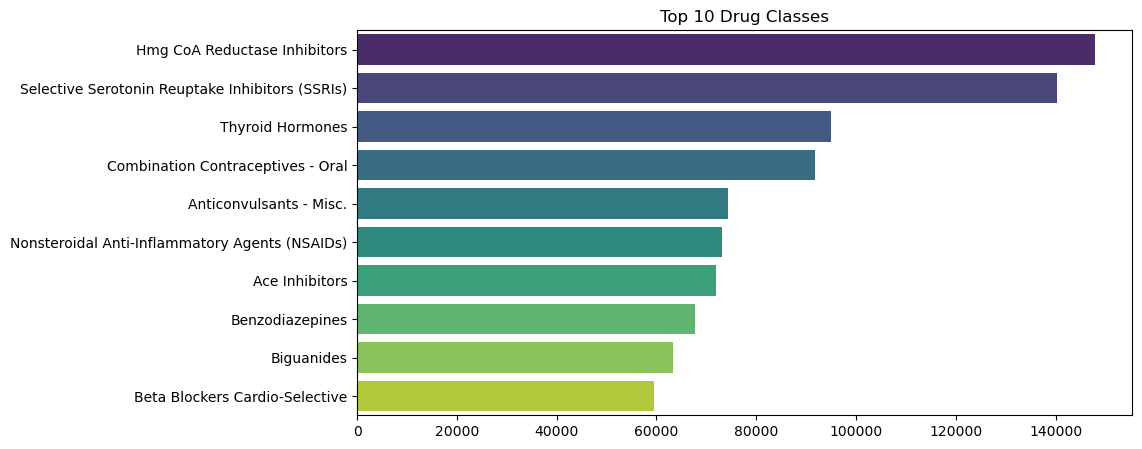

In [71]:
# Top 10 Drug categories
top_drugs = prescription_drugs['drug_category'].value_counts().head(10)
plt.figure(figsize=(10, 5))
sns.barplot(y=top_drugs.index, x=top_drugs.values, palette='viridis')
plt.title('Top 10 Drug Categories')
plt.show()

# Top 10 Drug Groups
top_drug_groups = prescription_drugs['drug_group'].value_counts().head(10)
plt.figure(figsize=(10, 5))
sns.barplot(y=top_drug_groups.index, x=top_drug_groups.values, palette='viridis')
plt.title('Top 10 Drug Groups')
plt.show()

# Top 10 Drug Classes
top_drug_classes = prescription_drugs['drug_class'].value_counts().head(10)
plt.figure(figsize=(10, 5))
sns.barplot(y=top_drug_classes.index, x=top_drug_classes.values, palette='viridis')
plt.title('Top 10 Drug Classes')
plt.show()


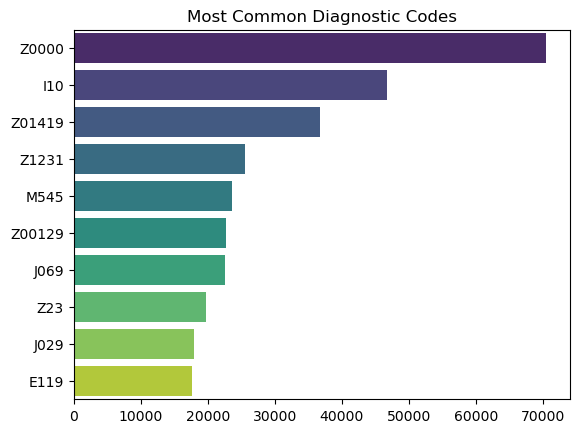

In [123]:
claims_per_diag = df['diag1'].value_counts().head(10)
sns.barplot(y=prescriptions_per_diag.index, x=prescriptions_per_diag.values, palette='viridis')
plt.title('Most Common Diagnostic Codes')
plt.show()

In [118]:
df[df['diag1'] == 'Z0000']['diag_desc'].unique()

array(['Encntr for general adult medical exam w/o abnormal findings'],
      dtype=object)

##### Looks like the most common diagnostic code is a general examination without any abnormal findings.

##### Look at some examples of diagnosis and associated ccs to determine a good characterization.

In [72]:
df[df.member_id == 'M0000001'][['date_svc', 'diag1', 'diag_desc', 'ccs_1_desc', 'ccs_2_desc', 'ccs_3_desc']]

,date_svc,diag1,diag_desc,ccs_1_desc,ccs_2_desc,ccs_3_desc
0,2015-12-06,N926,"Irregular menstruation, unspecified",Diseases of the genitourinary system,Diseases of female genital organs,Menstrual disorders
1,2015-12-06,O26842,"Uterine size-date discrepancy, second trimester",Complications of pregnancy; childbirth; and th...,Complications mainly related to pregnancy,Other complications of pregnancy
2,2015-12-13,O26842,"Uterine size-date discrepancy, second trimester",Complications of pregnancy; childbirth; and th...,Complications mainly related to pregnancy,Other complications of pregnancy
3,2016-02-29,O26843,"Uterine size-date discrepancy, third trimester",Complications of pregnancy; childbirth; and th...,Complications mainly related to pregnancy,Other complications of pregnancy
4,2016-03-27,O26843,"Uterine size-date discrepancy, third trimester",Complications of pregnancy; childbirth; and th...,Complications mainly related to pregnancy,Other complications of pregnancy
5,2016-04-03,O26843,"Uterine size-date discrepancy, third trimester",Complications of pregnancy; childbirth; and th...,Complications mainly related to pregnancy,Other complications of pregnancy
6,2016-04-10,O26843,"Uterine size-date discrepancy, third trimester",Complications of pregnancy; childbirth; and th...,Complications mainly related to pregnancy,Other complications of pregnancy
7,2016-04-11,O26843,"Uterine size-date discrepancy, third trimester",Complications of pregnancy; childbirth; and th...,Complications mainly related to pregnancy,Other complications of pregnancy
8,2016-04-13,O3421,Maternal care for scar from previous cesarean ...,Complications of pregnancy; childbirth; and th...,Indications for care in pregnancy; labor; and ...,Previous C-section
9,2016-04-13,O80,Encounter for full-term uncomplicated delivery,Complications of pregnancy; childbirth; and th...,Normal pregnancy and/or delivery [196.],Other pregnancy and delivery including normal


In [73]:
df[df.member_id == 'M0000001'][['diag1', 'diag_desc', 'ccs_1_desc', 'ccs_2_desc', 'ccs_3_desc']].drop_duplicates('diag1')

,diag1,diag_desc,ccs_1_desc,ccs_2_desc,ccs_3_desc
0,N926,"Irregular menstruation, unspecified",Diseases of the genitourinary system,Diseases of female genital organs,Menstrual disorders
1,O26842,"Uterine size-date discrepancy, second trimester",Complications of pregnancy; childbirth; and th...,Complications mainly related to pregnancy,Other complications of pregnancy
3,O26843,"Uterine size-date discrepancy, third trimester",Complications of pregnancy; childbirth; and th...,Complications mainly related to pregnancy,Other complications of pregnancy
8,O3421,Maternal care for scar from previous cesarean ...,Complications of pregnancy; childbirth; and th...,Indications for care in pregnancy; labor; and ...,Previous C-section
9,O80,Encounter for full-term uncomplicated delivery,Complications of pregnancy; childbirth; and th...,Normal pregnancy and/or delivery [196.],Other pregnancy and delivery including normal
10,Z3801,"Single liveborn infant, delivered by cesarean",Certain conditions originating in the perinata...,Liveborn [218.],Liveborn


In [74]:
df[df.member_id == 'M0000002'][['date_svc', 'diag1', 'diag_desc', 'ccs_1_desc', 'ccs_2_desc', 'ccs_3_desc']]

,date_svc,diag1,diag_desc,ccs_1_desc,ccs_2_desc,ccs_3_desc
15,2016-02-23,Z8249,Family hx of ischem heart dis and oth dis of t...,Residual codes; unclassified; all E codes [259...,,Residual codes; unclassified
16,2017-01-31,F4320,"Adjustment disorder, unspecified",Mental Illness,Adjustment disorders [650],Adjustment disorders
17,2017-01-31,Z0000,Encntr for general adult medical exam w/o abno...,Symptoms; signs; and ill-defined conditions an...,Factors influencing health care,Medical examination/evaluation
18,2017-05-19,R079,"Chest pain, unspecified",Diseases of the circulatory system,Diseases of the heart,Nonspecific chest pain
19,2017-05-20,R0789,Other chest pain,Diseases of the circulatory system,Diseases of the heart,Nonspecific chest pain
20,2017-06-05,I25118,Athscl heart disease of native cor art w oth a...,Diseases of the circulatory system,Diseases of the heart,Coronary atherosclerosis and other heart disease


In [75]:
df[df.member_id == 'M0000002'][['diag1', 'diag_desc', 'ccs_1_desc', 'ccs_2_desc', 'ccs_3_desc']].drop_duplicates('diag1')

,diag1,diag_desc,ccs_1_desc,ccs_2_desc,ccs_3_desc
15,Z8249,Family hx of ischem heart dis and oth dis of t...,Residual codes; unclassified; all E codes [259...,,Residual codes; unclassified
16,F4320,"Adjustment disorder, unspecified",Mental Illness,Adjustment disorders [650],Adjustment disorders
17,Z0000,Encntr for general adult medical exam w/o abno...,Symptoms; signs; and ill-defined conditions an...,Factors influencing health care,Medical examination/evaluation
18,R079,"Chest pain, unspecified",Diseases of the circulatory system,Diseases of the heart,Nonspecific chest pain
19,R0789,Other chest pain,Diseases of the circulatory system,Diseases of the heart,Nonspecific chest pain
20,I25118,Athscl heart disease of native cor art w oth a...,Diseases of the circulatory system,Diseases of the heart,Coronary atherosclerosis and other heart disease


In [76]:
df[df.ccs_2_desc == 'Factors influencing health care'].head(10)[['diag_desc', 'ccs_1_desc', 'ccs_2_desc', 'ccs_3_desc']]

,diag_desc,ccs_1_desc,ccs_2_desc,ccs_3_desc
17,Encntr for general adult medical exam w/o abno...,Symptoms; signs; and ill-defined conditions an...,Factors influencing health care,Medical examination/evaluation
23,Encntr for general adult medical exam w/o abno...,Symptoms; signs; and ill-defined conditions an...,Factors influencing health care,Medical examination/evaluation
28,Encntr for general adult medical exam w/o abno...,Symptoms; signs; and ill-defined conditions an...,Factors influencing health care,Medical examination/evaluation
41,Encounter for suspected problem with fetal gro...,Symptoms; signs; and ill-defined conditions an...,Factors influencing health care,Other screening for suspected conditions (not ...
43,Encounter for suspected problem with fetal gro...,Symptoms; signs; and ill-defined conditions an...,Factors influencing health care,Other screening for suspected conditions (not ...
59,Encntr for gyn exam (general) (routine) w/o ab...,Symptoms; signs; and ill-defined conditions an...,Factors influencing health care,Medical examination/evaluation
66,Encounter for antenatal screening of mother,Symptoms; signs; and ill-defined conditions an...,Factors influencing health care,Other screening for suspected conditions (not ...
69,Encounter for antenatal screening of mother,Symptoms; signs; and ill-defined conditions an...,Factors influencing health care,Other screening for suspected conditions (not ...
76,Other specified counseling,Symptoms; signs; and ill-defined conditions an...,Factors influencing health care,Administrative/social admission
77,Encntr for general adult medical exam w/o abno...,Symptoms; signs; and ill-defined conditions an...,Factors influencing health care,Medical examination/evaluation


In [83]:
df.groupby('member_id').count()['record_id'].describe()

count    245165.000000
mean          7.831138
std          14.923971
min           1.000000
25%           2.000000
50%           4.000000
75%           8.000000
max         921.000000
Name: record_id, dtype: float64

##### Median and mean are pretty close to each other so there aren't too many members with an extremely high count of claims.

##### Given more time I would want to investigate some of the members with a high number of claims to see if those are members with chronic health issues or potentially a data issue.

## 1. Build a characterization of a member’s health status based on their outpatient data.

There are many approaches for characterizing a member's health status from their outpatient data. I will outline and discuss several.
1. Since ccs_1_desc seems to be the most high level diagnosis, we could get all of the distinct values found in this column for a member and construct it into a sentence. To make the sentence shorter, we can only select the most frequent or two most frequent values.
    - The downside of this approach is it may create a profile that is out of date or that  ignores the other conditions they have been diagnosed with.
2. Create a mapping that categorizes conditions as Chronic, Acute, or Other. Including this information in the health profile will tell us if we expect an individual to continuously refill medication and vice versa.
    - Downside is that this requires domain knowledge and it is a lot of work to make a mapping for all conditions. Moreover, there could be nuances with certain conditions that make it more difficult to categorize.
3. More complicated health status may take into account frequency and recency of visits to determine the most relevant health conditions to the current status.
    - Further EDA would be necessary, but you could create some coefficient value that is a weighted combination of recency and frequency of the different conditions and pick the most relevant ones based on this coefficient.
    - Downside is that you may be ignoring conditions that a member was diagnosed with, but doesn't necessarily need follow up. The member may have very infrequent checks for this condition and may not be taking medications for it, but it is still relevant to the health status.
4. Summarizing outpatient data using an LLM and prompt engineering. This can be taken a step further by labeling data with desired summaries and finetuning the model to this specific task.
    - This option is the most work, but with good prompt engineering and fine tuning, you can achieve a very robust health status that can be translated to different audiences. 
    - This option may also not be ideal with the second task in the pdf in mind.
    - Experimenting with different prompts would be essential

##### After spot checking some records, I've come to the conclusion that diag_desc is too granular and won't be as useful for providing a high level characterization of a person's health status given the time constraints. However, for future work, it could be useful for additional feature extraction when trying to determine what could be prescribed based on the diagnosis description. 

In [124]:
df.head()

,record_id,member_id,date_svc,diag1,diag,diag_desc,ccs_1_desc,ccs_2_desc,ccs_3_desc
0,57738,M0000001,2015-12-06,N926,N926,"Irregular menstruation, unspecified",Diseases of the genitourinary system,Diseases of female genital organs,Menstrual disorders
1,57750,M0000001,2015-12-06,O26842,O26842,"Uterine size-date discrepancy, second trimester",Complications of pregnancy; childbirth; and th...,Complications mainly related to pregnancy,Other complications of pregnancy
2,65072,M0000001,2015-12-13,O26842,O26842,"Uterine size-date discrepancy, second trimester",Complications of pregnancy; childbirth; and th...,Complications mainly related to pregnancy,Other complications of pregnancy
3,201796,M0000001,2016-02-29,O26843,O26843,"Uterine size-date discrepancy, third trimester",Complications of pregnancy; childbirth; and th...,Complications mainly related to pregnancy,Other complications of pregnancy
4,267197,M0000001,2016-03-27,O26843,O26843,"Uterine size-date discrepancy, third trimester",Complications of pregnancy; childbirth; and th...,Complications mainly related to pregnancy,Other complications of pregnancy


In [125]:
member_health_status = df.groupby('member_id').agg(Most_Common_Condition=('ccs_1_desc', lambda x: x.value_counts().index[0] if len(x.value_counts())>0 else None))

member_health_status.reset_index(inplace=True)

In [202]:
def print_health_status(member_id):
    member = member_health_status[member_health_status['member_id'] == member_id].iloc[0]
    print(f"Member {member_id} has been diagnosed primarily with {member['Most_Common_Condition']}.")
    
def get_health_status(member_id, date):
    member_data = df[(df['member_id'] == member_id) & (df['date_svc'] <= date)]
    if member_data.empty:
        return 'No Data'
    else:
        health_status = member_data.agg(Most_Common_Condition=('ccs_1_desc', 
                                                               lambda x: x.value_counts().index[0] 
                                                               if not x.empty and len(x.value_counts()) > 0 
                                                               else 'No Condition')).iloc[0][0]
        return health_status



In [136]:
print_health_status('M0000001')

Member M0000001 has been diagnosed primarily with Complications of pregnancy; childbirth; and the puerperium.


##### This is a very simple implementation of a health profile. Given additional time other options that were outlined could be explored.

##### Below I experiment with the output from gpt 3.5

In [117]:
openai.api_key = os.getenv('OPENAI_API_KEY')

In [184]:
prompt = '''
Provide a high level description of a members health status.
The input consists of the date of the claim (date_svc), diagnostic description (diag_desc) and 
three outputs from clinical classification software ('ccs_1_desc', 'ccs_2_desc', 'ccs_3_desc').
Not all information will be available for each member. Limit your response to the high level health conditions in one sentence. Data: {}
'''

In [238]:
test_prompt = '''
Given the following outpatient data for a patient, please provide a high-level summary of their health status 
using Clinical Classifications Software (CCS) mapping. Summarize key health events, conditions, or diseases 
such as chronic illnesses, recent injuries, or surgeries, but it doesn't need to be overly detailed. 
The goal is to provide a one sentence robust and useful characterization of the member's health status. Data: {}
'''

In [145]:
input_data = df[df.member_id == 'M0000001'][['date_svc', 'diag1', 'diag_desc', 'ccs_1_desc', 'ccs_2_desc', 'ccs_3_desc']]

In [146]:
input_data.to_dict()

{'date_svc': {0: Timestamp('2015-12-06 00:00:00'),
  1: Timestamp('2015-12-06 00:00:00'),
  2: Timestamp('2015-12-13 00:00:00'),
  3: Timestamp('2016-02-29 00:00:00'),
  4: Timestamp('2016-03-27 00:00:00'),
  5: Timestamp('2016-04-03 00:00:00'),
  6: Timestamp('2016-04-10 00:00:00'),
  7: Timestamp('2016-04-11 00:00:00'),
  8: Timestamp('2016-04-13 00:00:00'),
  9: Timestamp('2016-04-13 00:00:00'),
  10: Timestamp('2016-04-13 00:00:00'),
  11: Timestamp('2016-04-14 00:00:00'),
  12: Timestamp('2016-04-15 00:00:00'),
  13: Timestamp('2016-04-16 00:00:00'),
  14: Timestamp('2016-04-17 00:00:00')},
 'diag1': {0: 'N926',
  1: 'O26842',
  2: 'O26842',
  3: 'O26843',
  4: 'O26843',
  5: 'O26843',
  6: 'O26843',
  7: 'O26843',
  8: 'O3421',
  9: 'O80',
  10: 'Z3801',
  11: 'Z3801',
  12: 'Z3801',
  13: 'Z3801',
  14: 'Z3801'},
 'diag_desc': {0: 'Irregular menstruation, unspecified',
  1: 'Uterine size-date discrepancy, second trimester',
  2: 'Uterine size-date discrepancy, second trimester',

In [185]:
res = openai.ChatCompletion.create(model="gpt-3.5-turbo", 
                                   max_tokens=100,
                                   temperature=0.7,
                                   top_p=0.5,
                                   frequency_penalty=0.5,
                                   messages=[
                                       {
                                           "role": "system",
                                           "content": "You are a helpful assistant for medical record summarization.",
                                       },
                                       {
                                           "role": "user",
                                           "content": prompt.format(input_data.to_dict()),
                                       },
                                   ],
                                  )
res["choices"][0]["message"]["content"]

"The member's high level health conditions include irregular menstruation, uterine size-date discrepancy, complications of pregnancy, and delivery of a single liveborn infant by cesarean."

In [239]:
res = openai.ChatCompletion.create(model="gpt-3.5-turbo", 
                                   max_tokens=100,
                                   temperature=0.7,
                                   top_p=0.5,
                                   frequency_penalty=0.5,
                                   messages=[
                                       {
                                           "role": "system",
                                           "content": "You are a helpful and exrtemely concise assistant for medical record summarization.",
                                       },
                                       {
                                           "role": "user",
                                           "content": test_prompt.format(input_data.to_dict()),
                                       },
                                   ],
                                  )
res["choices"][0]["message"]["content"]

'The patient has a history of irregular menstruation and uterine size-date discrepancy during pregnancy, with subsequent complications mainly related to pregnancy. They underwent a cesarean delivery and delivered a single liveborn infant.'

In [242]:
res = openai.ChatCompletion.create(model="gpt-3.5-turbo", 
                                   max_tokens=100,
                                   temperature=0.7,
                                   top_p=0.5,
                                   frequency_penalty=0.5,
                                   messages=[
                                       {
                                           "role": "system",
                                           "content": "You are a helpful and exrtemely concise assistant for medical record summarization.",
                                       },
                                       {
                                           "role": "user",
                                           "content": test_prompt.format(input_data.to_dict()),
                                       },
                                   ],
                                  )
res["choices"][0]["message"]["content"]

"The patient has a history of irregular menstruation, uterine size-date discrepancy during pregnancy, and has undergone a previous cesarean delivery. They recently had an uncomplicated full-term delivery via cesarean section. Overall, the patient's health status is related to complications of pregnancy and childbirth."

## 2. Investigate how to infer this health status from the prescription drug data alone

##### We will proceed with the simple option of health status for this step. We cannot apply the function to the dataset as is because during training and testing, the prescription could have been filled at any point. So, the health status needs to be determined as of the time of the prescription being filled.

In [147]:
prescription_drugs.head()

,record_id,member_id,date_svc,ndc,drug_category,drug_group,drug_class,YearMonth
0,4115084976453758912,M0023556,2016-05-08,51285040702,Estrogens,Estrogens,Estrogens,2016-05
1,1750642805638674193,M0087538,2016-12-05,50474080303,Antiparkinson and Related Therapy Agents,Antiparkinson Dopaminergics,Nonergoline Dopamine Receptor Agonists,2016-12
2,5543689263541245391,M0049608,2018-01-18,3089421,Anticoagulants,Direct Factor Xa Inhibitors,Direct Factor Xa Inhibitors,2018-01
3,5952194046467620061,M0175153,2017-01-28,603580321,Gastrointestinal Agents - Misc.,Inflammatory Bowel Agents,Inflammatory Bowel Agents,2017-01
4,1809570950798791089,M0152187,2016-05-13,591396501,Progestins,Progestins,Progestins,2016-05


In [203]:
health_status = prescription_drugs.apply(lambda row: get_health_status(member_id=row['member_id'], 
                                                                       date=row['date_svc']), axis=1)

In [ ]:
prescription_drugs['health_status'] = health_status

##### Lets add some features that may be useful

In [ ]:
for col in ['drug_category', 'drug_group', 'drug_class']:
    prescription_drugs[col] = prescription_drugs[col].astype('category')

for col in ['drug_category', 'drug_group', 'drug_class']:
    prescription_drugs[f'total_unique_{col}'] = prescription_drugs.groupby(['member_id', col]).cumcount() + 1

for col in ['drug_category', 'drug_group', 'drug_class']:
    prescription_drugs[f'total_unique_{col}'] = prescription_drugs.groupby(['member_id', 'date_svc'])[f'total_unique_{col}'].transform(max)

In [ ]:
categorical_cols = ['drug_category', 'drug_group', 'drug_class']

numeric_cols = ['total_unique_drug_category', 
                'total_unique_drug_group', 'total_unique_drug_class']

features = categorical_cols + numeric_cols

target = 'health_status'

X_train, X_test, y_train, y_test = train_test_split(prescription_drugs[features], 
                                                    prescription_drugs[target], 
                                                    test_size=0.2, random_state=42)

cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

num_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, numeric_cols),
        ('cat', cat_transformer, categorical_cols)])

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', GradientBoostingClassifier(random_state=42))])

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

model = pipeline.named_steps['classifier']

Due to the size of datasets, it is taking a very long time for me to run some of these things locally. I provided the code that I would like to use, but did not run everything. Obviously, this would be a first iteration model and additional steps could be taken to improve it. Examples of steps that could be taken to improve the model are cross validation, additional feature engineering, experimentation with other models, feature importance, and optimizing for different reward functions depending on the use case.

I expect the base model to perform decently well due to the relatively loose health status definition that we constructed. One of the more difficult constructions would also require more feature engineering work for comparable performance. More useful health status could be constructed through a combination of recency and frequency of diagnosis and could even potentially take into account prescription drug history.

Our model could be used to identify members that are either receiving a prescription they should not be receiving or not receiving a prescription that they potentially should be. It could be used in a larger ecosystem for cost estimation and projecting prescriptions that will be filled in the future. 

The LLM approach could give a summarized medical history for the customer as a front facing interface.

I didn't tie together the prescription data with the claims data, but that would be an additional step to do. To do this however, EDA would need to be done to see the relationship between when a claim occurs and when a prescription is filled. Even though a member had a claim, they could potentially wait weeks to fill it and maybe even have other claims in between. This relationship should be studied and domain knowledge should also be taken into account.